# Instructions to run this notebook

This notebook is divided into 2 main sections:
1. Titanic Dataset
> Sub-sections 1.1 to 1.3 are cleaning steps. If you wish to use the cleaned datasets directly, skip to sub-sections 1.4 onwards.
2. Cifar-10 Image Classification
> Run all cells in this section normally. No special instructions.

**Section 1: Titanic Dataset** 
- 1.1 Exploratory Data Analysis
- 1.2 Data Pre-processing
    - 1.2.1 Handling Missing Values
    - 1.2.2 Attributes Selection
    - 1.2.3 Feature Engineering
        - 1.2.3.1 SibSp and Parch Attributes
        - 1.2.3.2 Age Attribute
        - 1.2.3.3 Fare Attribute
    - 1.2.4 One-Hot Encoding for Categorical Variables
- 1.3 Save Cleaned Training Data and Test Data
- 1.4 Import Cleaned Training Data and Test Data
- 1.5 Create Models for Stratified 10-Fold Cross Validation Training
    - 1.5.1 Random Forest Classifier
    - 1.5.2 Support Vector Machine
    - 1.5.3 Neural Network
    - 1.5.4 Convolutional Neural Network
- 1.6 Prediction on Test Dataset using Neural Network

**Section 2: Cifar-10 Image Classification**

# 1. Titanic Dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from statistics import mean, stdev

pd.set_option('display.max_colwidth', 140)

Using TensorFlow backend.


In [215]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [216]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.1 Exploratory Data Analysis

In [217]:
# Overview of training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [218]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [219]:
# Overview of test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [220]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [221]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [222]:
# Check for null values in training data
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [223]:
# Check for null values in test data
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 1.2 Data Pre-processing

### 1.2.1 Handling Missing Values

In [224]:
print("The mean age in training data is: {}".format(round(train['Age'].mean(axis=0, skipna=True),2)))
print("The median age in training data is: {}".format(train['Age'].median()))

print("The mean age in test data is: {}".format(round(test['Age'].mean(axis=0, skipna=True),2)))
print("The median age in test data is: {}".format(test['Age'].median()))

The mean age in training data is: 29.7
The median age in training data is: 28.0
The mean age in test data is: 30.27
The median age in test data is: 27.0


In [225]:
# Fill null values in Age column with median age
train['Age'].fillna(28.0, inplace=True)
test['Age'].fillna(27.0, inplace=True)

In [226]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [227]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [228]:
# Check the updated mean and median age values
print("The updated mean age in training data is: {}".format(round(train['Age'].mean(axis=0, skipna=True),2)))
print("The updated median age in training data is: {}".format(train['Age'].median()))

print("The updated mean age in test data is: {}".format(round(test['Age'].mean(axis=0, skipna=True),2)))
print("The updated median age in test data is: {}".format(test['Age'].median()))

The updated mean age in training data is: 29.36
The updated median age in training data is: 28.0
The updated mean age in test data is: 29.6
The updated median age in test data is: 27.0


In [229]:
# Display rows with Embarked column equals to null
print(train[train['Embarked'].isna()])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


In [230]:
# Find training samples having Pclass=1 and Embarked=Queenstown
Q_Class1 = train.loc[(train['Pclass']==1) & (train['Embarked']=='Q')]
Q_Class1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0,C78,Q
412,413,1,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0,C78,Q


In [231]:
# Find training samples having Pclass=1 and Embarked=Cherbourg
C_Class1 = train.loc[(train['Pclass']==1) & (train['Embarked']=='C')]
C_Class1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,28.0,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,1,"Marechal, Mr. Pierre",male,28.0,0,0,11774,29.7000,C47,C
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,28.0,1,0,17453,89.1042,C92,C
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C


In [232]:
# Find training samples having Pclass=1 and Embarked=Southampton
S_Class1 = train.loc[(train['Pclass']==1) & (train['Embarked']=='S')]
S_Class1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
...,...,...,...,...,...,...,...,...,...,...,...,...
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Barron)",female,48.0,0,0,17466,25.9292,D17,S
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S


In [233]:
print("The mean ticket fare for PClass 1 at Queenstown is: {}".format(round(Q_Class1['Fare'].mean(axis=0, skipna=True),2)))
print("The median ticket fare for PClass 1 at Queenstown: {}".format(Q_Class1['Fare'].median()))

print("The mean ticket fare for PClass 1 at Cherbourg is: {}".format(round(C_Class1['Fare'].mean(axis=0, skipna=True),2)))
print("The median ticket fare for PClass 1 at Cherbourg: {}".format(C_Class1['Fare'].median()))

print("The mean ticket fare for PClass 1 at Southampton is: {}".format(round(S_Class1['Fare'].mean(axis=0, skipna=True),2)))
print("The median ticket fare for PClass 1 at Southampton: {}".format(S_Class1['Fare'].median()))

The mean ticket fare for PClass 1 at Queenstown is: 90.0
The median ticket fare for PClass 1 at Queenstown: 90.0
The mean ticket fare for PClass 1 at Cherbourg is: 104.72
The median ticket fare for PClass 1 at Cherbourg: 78.2667
The mean ticket fare for PClass 1 at Southampton is: 70.36
The median ticket fare for PClass 1 at Southampton: 52.0


In [234]:
# Fill null values in Embarked column with "Cherbourg"
train['Embarked'].fillna('C', inplace=True)

In [235]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [236]:
# Display rows with Fare column equals to null in test data
print(test[test['Fare'].isna()])

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


In [237]:
# Find test samples having Pclass=3 and Embarked=Southampton
S_Class3 = test.loc[(test['Pclass']==3) & (test['Embarked']=='S')]
S_Class3

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
409,1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,NaN,S
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [238]:
print("The mean ticket fare for PClass 3 at Southampton is: {}".format(round(S_Class3['Fare'].mean(axis=0, skipna=True),2)))
print("The median ticket fare for PClass 3 at Southampton: {}".format(S_Class3['Fare'].median()))

The mean ticket fare for PClass 3 at Southampton is: 13.91
The median ticket fare for PClass 3 at Southampton: 8.05


In [239]:
# Fill null values in Fare column with median ticket fare at "Cherbourg"
test['Fare'].fillna(8.05, inplace=True)
test.iloc[152]

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                         8.05
Cabin                         NaN
Embarked                        S
Name: 152, dtype: object

In [240]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

### 1.2.2 Attributes Selection

In [241]:
# Only important attributes are selected
X_train = train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X_test = test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y_train = train[['Survived']]

In [242]:
X_train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [243]:
X_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [244]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [245]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [246]:
y_train.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [247]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(891, 7)
(418, 7)
(891, 1)


### 1.2.3 Feature Engineering

#### 1.2.3.1 SibSp and Parch Attributes

In [248]:
# Combine 'SibSp' and 'Parch' into one attribute called 'FamilySize'
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch']
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch']

# If FamilySize>=1 means passenger is onboard with family members, otherwise no.
X_train['Family'] = np.where(X_train['FamilySize']>=1, 'yes', 'no')
X_test['Family'] = np.where(X_test['FamilySize']>=1, 'yes', 'no')

C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying

In [249]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Family
0,3,male,22.0,1,0,7.2500,S,1,yes
1,1,female,38.0,1,0,71.2833,C,1,yes
2,3,female,26.0,0,0,7.9250,S,0,no
3,1,female,35.0,1,0,53.1000,S,1,yes
4,3,male,35.0,0,0,8.0500,S,0,no


In [250]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Family
0,3,male,34.5,0,0,7.8292,Q,0,no
1,3,female,47.0,1,0,7.0000,S,1,yes
2,2,male,62.0,0,0,9.6875,Q,0,no
3,3,male,27.0,0,0,8.6625,S,0,no
4,3,female,22.0,1,1,12.2875,S,2,yes


In [251]:
# Drop 'SibSp', 'Parch', and 'FamilySize' columns
X_train = X_train.drop(['SibSp','Parch','FamilySize'], axis=1)
X_test = X_test.drop(['SibSp','Parch','FamilySize'], axis=1)

#### 1.2.3.2 Age Attribute

In [252]:
X_train['Age'].value_counts()

28.00    202
24.00     30
22.00     27
18.00     26
19.00     25
        ... 
55.50      1
70.50      1
66.00      1
23.50      1
0.42       1
Name: Age, Length: 88, dtype: int64

In [253]:
X_test['Age'].value_counts()

27.0    98
24.0    17
21.0    17
22.0    16
30.0    15
        ..
7.0      1
60.5     1
26.5     1
76.0     1
34.5     1
Name: Age, Length: 79, dtype: int64

In [254]:
X_train['Age'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [255]:
X_test['Age'].describe()

count    418.000000
mean      29.599282
std       12.703770
min        0.170000
25%       23.000000
50%       27.000000
75%       35.750000
max       76.000000
Name: Age, dtype: float64

In [256]:
# Categorise range of ages in training dataset into 5 age groups
for row in X_train:
    X_train['AgeGroup'] = X_train['Age'].astype(int)
    X_train.loc[X_train['AgeGroup']<=17, 'AgeGroup']=0
    X_train.loc[(X_train['AgeGroup']>17) & (X_train['AgeGroup']<=27), 'AgeGroup']=1
    X_train.loc[(X_train['AgeGroup']>27) & (X_train['AgeGroup']<=35), 'AgeGroup']=2
    X_train.loc[(X_train['AgeGroup']>35) & (X_train['AgeGroup']<=45), 'AgeGroup']=3
    X_train.loc[X_train['AgeGroup']>45, 'AgeGroup']=4

X_train['AgeGroup'].value_counts()

2    337
1    224
3    116
0    113
4    101
Name: AgeGroup, dtype: int64

In [257]:
# Categorise range of ages in test dataset into 5 age groups
for row in X_test:
    X_test['AgeGroup'] = X_test['Age'].astype(int)
    X_test.loc[X_test['AgeGroup']<=17, 'AgeGroup']=0
    X_test.loc[(X_test['AgeGroup']>17) & (X_test['AgeGroup']<=27), 'AgeGroup']=1
    X_test.loc[(X_test['AgeGroup']>27) & (X_test['AgeGroup']<=35), 'AgeGroup']=2
    X_test.loc[(X_test['AgeGroup']>35) & (X_test['AgeGroup']<=45), 'AgeGroup']=3
    X_test.loc[X_test['AgeGroup']>45, 'AgeGroup']=4
    
X_test['AgeGroup'].value_counts()

1    212
2     60
3     53
4     52
0     41
Name: AgeGroup, dtype: int64

In [258]:
X_train['AgeGroup'].describe()

count    891.000000
mean       1.851852
std        1.149716
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: AgeGroup, dtype: float64

In [259]:
X_test['AgeGroup'].describe()

count    418.000000
mean       1.672249
std        1.191595
min        0.000000
25%        1.000000
50%        1.000000
75%        2.750000
max        4.000000
Name: AgeGroup, dtype: float64

In [260]:
# Drop 'Age' column
X_train = X_train.drop(['Age'], axis=1)
X_test = X_test.drop(['Age'], axis=1)

In [261]:
X_train.head()

,Pclass,Sex,Fare,Embarked,Family,AgeGroup
0,3,male,7.2500,S,yes,1
1,1,female,71.2833,C,yes,3
2,3,female,7.9250,S,no,1
3,1,female,53.1000,S,yes,2
4,3,male,8.0500,S,no,2


#### 1.2.3.3 Fare Attribute

In [262]:
X_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [263]:
X_test['Fare'].describe()

count    418.000000
mean      35.561214
std       55.856789
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64

In [264]:
# Categorise range of fares in training dataset into 5 fare groups
for row in X_train:
    X_train['FareGroup'] = X_train['Fare']
    X_train.loc[X_train['FareGroup']<=8, 'FareGroup']=0
    X_train.loc[(X_train['FareGroup']>8) & (X_train['FareGroup']<=20), 'FareGroup']=1
    X_train.loc[(X_train['FareGroup']>20) & (X_train['FareGroup']<=50), 'FareGroup']=2
    X_train.loc[(X_train['FareGroup']>50) & (X_train['FareGroup']<=80), 'FareGroup']=3
    X_train.loc[X_train['FareGroup']>80, 'FareGroup']=4
    
X_train['FareGroup'] = X_train['FareGroup'].astype(int)
X_train['FareGroup'].value_counts()

1    274
0    241
2    216
3     86
4     74
Name: FareGroup, dtype: int64

In [265]:
# Categorise range of fares in test dataset into 5 fare groups
for row in X_test:
    X_test['FareGroup'] = X_test['Fare']
    X_test.loc[X_test['FareGroup']<=8, 'FareGroup']=0
    X_test.loc[(X_test['FareGroup']>8) & (X_test['FareGroup']<=20), 'FareGroup']=1
    X_test.loc[(X_test['FareGroup']>20) & (X_test['FareGroup']<=50), 'FareGroup']=2
    X_test.loc[(X_test['FareGroup']>50) & (X_test['FareGroup']<=80), 'FareGroup']=3
    X_test.loc[X_test['FareGroup']>80, 'FareGroup']=4
    
X_test['FareGroup'] = X_test['FareGroup'].astype(int)
X_test['FareGroup'].value_counts()

1    119
0    119
2    100
4     41
3     39
Name: FareGroup, dtype: int64

In [266]:
X_train['FareGroup'].describe()

count    891.000000
mean       1.414141
std        1.215158
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: FareGroup, dtype: float64

In [267]:
X_test['FareGroup'].describe()

count    418.000000
mean       1.435407
std        1.262592
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: FareGroup, dtype: float64

In [268]:
# Drop 'Fare' column
X_train = X_train.drop(['Fare'], axis=1)
X_test = X_test.drop(['Fare'], axis=1)

In [269]:
X_train.head()

,Pclass,Sex,Embarked,Family,AgeGroup,FareGroup
0,3,male,S,yes,1,0
1,1,female,C,yes,3,3
2,3,female,S,no,1,0
3,1,female,S,yes,2,3
4,3,male,S,no,2,1


### 1.2.4 One-Hot Encoding for Categorical Variables

In [270]:
# One-hot encoding for categorical variables
X_train = pd.get_dummies(X_train, prefix=['Pclass','Sex','Embarked','Family', 'AgeGroup', 'FareGroup'], 
                         columns=['Pclass','Sex','Embarked','Family', 'AgeGroup', 'FareGroup'])
X_test = pd.get_dummies(X_test, prefix=['Pclass','Sex','Embarked','Family', 'AgeGroup', 'FareGroup'], 
                         columns=['Pclass','Sex','Embarked','Family', 'AgeGroup', 'FareGroup'])

X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_no,Family_yes,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,FareGroup_0,FareGroup_1,FareGroup_2,FareGroup_3,FareGroup_4
0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0


In [271]:
X_test.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_no,Family_yes,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,FareGroup_0,FareGroup_1,FareGroup_2,FareGroup_3,FareGroup_4
0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0
1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0
2,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0
3,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0
4,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0


In [272]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(891, 20)
(418, 20)
(891, 1)


## 1.3 Save Cleaned Training Data and Test Data

In [273]:
X_train.to_csv('X_train_cleaned1.csv', index=False, header=True)
X_test.to_csv('X_test_cleaned1.csv', index=False, header=True)
y_train.to_csv('y_train_cleaned1.csv', index=False, header=True)

## 1.4 Import Cleaned Training Data and Test Data

In [9]:
X_train = pd.read_csv("X_train_cleaned1.csv")
X_test = pd.read_csv("X_test_cleaned1.csv")
y_train = pd.read_csv("y_train_cleaned1.csv")

X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_no,Family_yes,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,FareGroup_0,FareGroup_1,FareGroup_2,FareGroup_3,FareGroup_4
0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0


In [10]:
# Reduce feature dimension by dropping FareGroup Columns
X_train = X_train.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)
X_test = X_test.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=222)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)

(712, 15)
(179, 15)
(418, 15)
(712, 1)
(179, 1)


In [13]:
# Convert dataframe to numpy array
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(712, 15)
(179, 15)
(418, 15)


In [15]:
# Convert labels to numpy arrays
y_train = y_train.values
y_val = y_val.values
print(type(y_train))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## 1.5 Create Models for Stratified 10-Fold Cross Validation Training

### 1.5.1 Random Forest Classifier

In [26]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=4, verbose=2)
rf_model = rf.fit(X_train, y_train)
rf_score = cross_val_score(rf_model, X_val, y_val, cv=10)
print('List of validation accuracy at each fold: {}'.format(rf_score))
print('\nMaximum Validation Accuracy: {}%'.format(round(max(rf_score)*100, 3)))
print('Minimum Validation Accuracy: {}%'.format(round(min(rf_score)*100, 3)))
print('Overall Validation Accuracy: {}%'.format(round(mean(rf_score)*100, 3)))
#print("\nValidation Accuracy: {}".format(round(rf_model.score(X_val, y_val), 3)))

C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### 1.5.2 Support Vector Machine

In [27]:
# Support Vector Machine
svm = SVC(kernel='linear', random_state=7, verbose=True)
svm_model = svm.fit(X_train, y_train)
svm_score = cross_val_score(svm_model, X_val, y_val, cv=10)
print('\nList of validation accuracy at each fold: {}'.format(svm_score))
print('\nMaximum Validation Accuracy: {}%'.format(round(max(svm_score)*100, 3)))
print('Minimum Validation Accuracy: {}%'.format(round(min(svm_score)*100, 3)))
print('Overall Validation Accuracy: {}%'.format(round(mean(svm_score)*100, 3)))
#print("\nValidation Accuracy: {}".format(round(svm_model.score(X_val, y_val), 3)))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of validation accuracy at each fold: [0.88888889 0.94444444 0.61111111 0.77777778 0.72222222 0.88888889
 0.88888889 0.83333333 0.66666667 0.82352941]

Maximum Validation Accuracy: 94.444%
Minimum Validation Accuracy: 61.111%
Overall Validation Accuracy: 80.458%


C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yirong\miniconda3\envs\python36_for_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataC

### 1.5.3 Neural Network

In [7]:
# Fully Connected Neural Network
def model_nn():
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, metrics, title):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

#### 1.5.3.1 Stratified 10-Fold Cross Validation

In [44]:
X_train = pd.read_csv("X_train_cleaned1.csv")
X_test = pd.read_csv("X_test_cleaned1.csv")
y_train = pd.read_csv("y_train_cleaned1.csv")

X_train = X_train.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)
X_test = X_test.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.values

print(type(X_train))
print(type(X_test))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [45]:
print(X_train.shape)
print(X_test.shape)

(891, 15)
(418, 15)


[Fold 1/10]
Train on 801 samples, validate on 90 samples
Epoch 1/100
801/801 [==============================] - 1s 1ms/step - loss: 0.6638 - accuracy: 0.5943 - val_loss: 0.6454 - val_accuracy: 0.6111
Epoch 2/100
801/801 [==============================] - 1s 774us/step - loss: 0.6645 - accuracy: 0.5980 - val_loss: 0.6489 - val_accuracy: 0.6111
Epoch 3/100
801/801 [==============================] - 1s 771us/step - loss: 0.6388 - accuracy: 0.6005 - val_loss: 0.5847 - val_accuracy: 0.6111
Epoch 4/100
801/801 [==============================] - 1s 752us/step - loss: 0.6098 - accuracy: 0.6180 - val_loss: 0.5996 - val_accuracy: 0.8111
Epoch 5/100
801/801 [==============================] - 1s 752us/step - loss: 0.5969 - accuracy: 0.6767 - val_loss: 0.6206 - val_accuracy: 0.8444
Epoch 6/100
801/801 [==============================] - 1s 773us/step - loss: 0.5896 - accuracy: 0.7303 - val_loss: 0.5958 - val_accuracy: 0.8444
Epoch 7/100
801/801 [==============================] - 1s 763us/step - loss

Epoch 57/100
801/801 [==============================] - 1s 731us/step - loss: 0.4534 - accuracy: 0.8077 - val_loss: 0.5268 - val_accuracy: 0.8222
Epoch 58/100
801/801 [==============================] - 1s 734us/step - loss: 0.4454 - accuracy: 0.8165 - val_loss: 0.5214 - val_accuracy: 0.8111
Epoch 59/100
801/801 [==============================] - 1s 739us/step - loss: 0.4422 - accuracy: 0.8190 - val_loss: 0.5444 - val_accuracy: 0.8111
Epoch 60/100
801/801 [==============================] - 1s 786us/step - loss: 0.4317 - accuracy: 0.8252 - val_loss: 0.5506 - val_accuracy: 0.8111
Epoch 61/100
801/801 [==============================] - 1s 864us/step - loss: 0.4388 - accuracy: 0.8090 - val_loss: 0.5546 - val_accuracy: 0.8111
Epoch 62/100
801/801 [==============================] - 1s 961us/step - loss: 0.4646 - accuracy: 0.8115 - val_loss: 0.5241 - val_accuracy: 0.8111
Epoch 63/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4535 - accuracy: 0.8127 - val_loss: 0.5537 - v

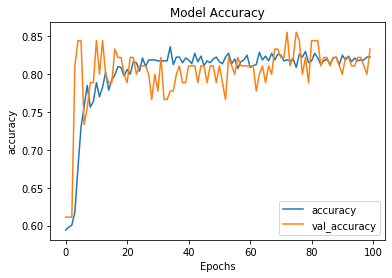

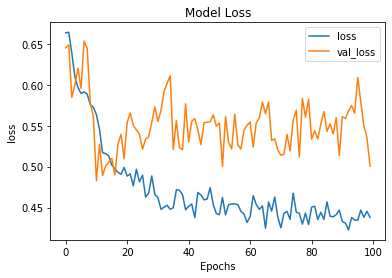

90/90 [==============================] - 0s 77us/step
[Fold 2/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.5561 - val_loss: 0.6741 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 688us/step - loss: 0.6729 - accuracy: 0.6209 - val_loss: 0.6628 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 709us/step - loss: 0.6541 - accuracy: 0.6022 - val_loss: 0.6337 - val_accuracy: 0.6180
Epoch 4/100
802/802 [==============================] - 1s 756us/step - loss: 0.6552 - accuracy: 0.6022 - val_loss: 0.6345 - val_accuracy: 0.6180
Epoch 5/100
802/802 [==============================] - 1s 864us/step - loss: 0.6321 - accuracy: 0.6072 - val_loss: 0.5895 - val_accuracy: 0.6180
Epoch 6/100
802/802 [==============================] - 1s 746us/step - loss: 0.6275 - accuracy: 0.6272 - val_loss: 0.5647 - val_accuracy: 0.7753
Epoch 7/100
802/802 [

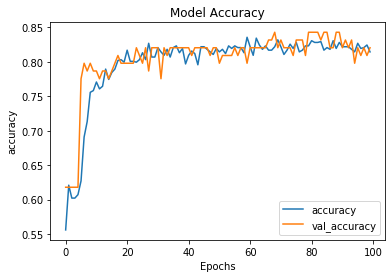

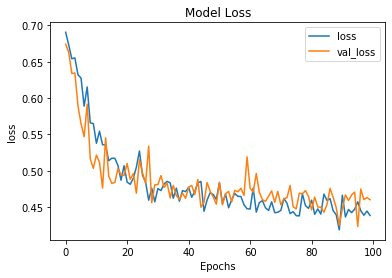

89/89 [==============================] - 0s 78us/step
[Fold 3/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6790 - accuracy: 0.5723 - val_loss: 0.6591 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 742us/step - loss: 0.6408 - accuracy: 0.5973 - val_loss: 0.6183 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 779us/step - loss: 0.6065 - accuracy: 0.6172 - val_loss: 0.5820 - val_accuracy: 0.7753
Epoch 4/100
802/802 [==============================] - 1s 758us/step - loss: 0.6097 - accuracy: 0.6983 - val_loss: 0.5885 - val_accuracy: 0.7416
Epoch 5/100
802/802 [==============================] - 1s 765us/step - loss: 0.6014 - accuracy: 0.7107 - val_loss: 0.5748 - val_accuracy: 0.7528
Epoch 6/100
802/802 [==============================] - 1s 746us/step - loss: 0.5829 - accuracy: 0.7431 - val_loss: 0.5772 - val_accuracy: 0.7528
Epoch 7/100
802/802 [

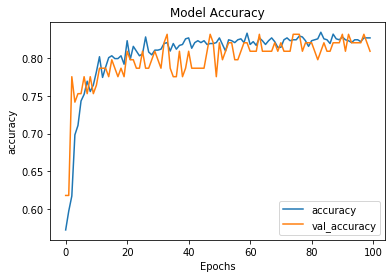

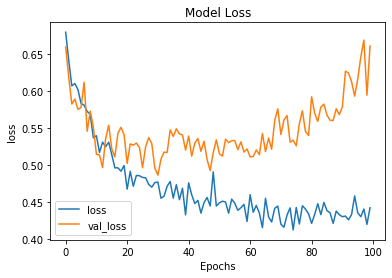

89/89 [==============================] - 0s 78us/step
[Fold 4/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6818 - accuracy: 0.5786 - val_loss: 0.6667 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 763us/step - loss: 0.6651 - accuracy: 0.6085 - val_loss: 0.6490 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 751us/step - loss: 0.6414 - accuracy: 0.6147 - val_loss: 0.6035 - val_accuracy: 0.6180
Epoch 4/100
802/802 [==============================] - 1s 736us/step - loss: 0.6365 - accuracy: 0.6185 - val_loss: 0.6189 - val_accuracy: 0.7528
Epoch 5/100
802/802 [==============================] - 1s 736us/step - loss: 0.6155 - accuracy: 0.6334 - val_loss: 0.5807 - val_accuracy: 0.7865
Epoch 6/100
802/802 [==============================] - 1s 732us/step - loss: 0.5982 - accuracy: 0.6608 - val_loss: 0.5738 - val_accuracy: 0.7753
Epoch 7/100
802/802 [

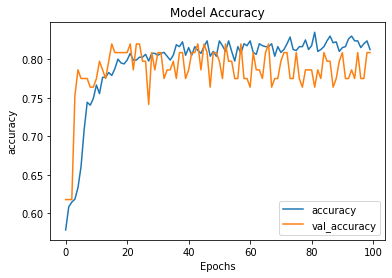

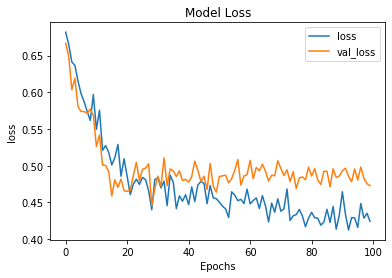

89/89 [==============================] - 0s 67us/step
[Fold 5/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6789 - accuracy: 0.5711 - val_loss: 0.6636 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 742us/step - loss: 0.6657 - accuracy: 0.6072 - val_loss: 0.6449 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 747us/step - loss: 0.6490 - accuracy: 0.6085 - val_loss: 0.6131 - val_accuracy: 0.6180
Epoch 4/100
802/802 [==============================] - 1s 755us/step - loss: 0.6156 - accuracy: 0.6234 - val_loss: 0.5859 - val_accuracy: 0.6517
Epoch 5/100
802/802 [==============================] - 1s 757us/step - loss: 0.6153 - accuracy: 0.6446 - val_loss: 0.5752 - val_accuracy: 0.7865
Epoch 6/100
802/802 [==============================] - 1s 767us/step - loss: 0.6032 - accuracy: 0.7007 - val_loss: 0.5744 - val_accuracy: 0.7978
Epoch 7/100
802/802 [

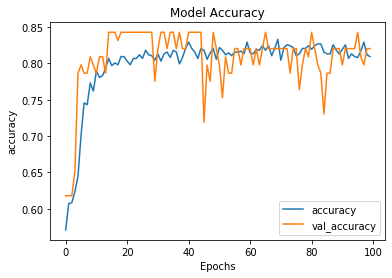

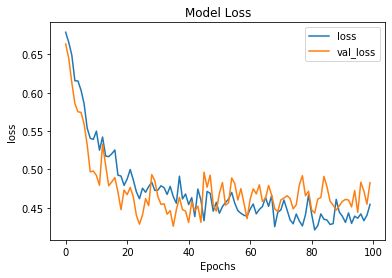

89/89 [==============================] - 0s 78us/step
[Fold 6/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6716 - accuracy: 0.6022 - val_loss: 0.6691 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 817us/step - loss: 0.6541 - accuracy: 0.6110 - val_loss: 0.6551 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 792us/step - loss: 0.6256 - accuracy: 0.6172 - val_loss: 0.6228 - val_accuracy: 0.7528
Epoch 4/100
802/802 [==============================] - 1s 821us/step - loss: 0.6044 - accuracy: 0.6309 - val_loss: 0.6237 - val_accuracy: 0.7079
Epoch 5/100
802/802 [==============================] - 1s 849us/step - loss: 0.5776 - accuracy: 0.7057 - val_loss: 0.6494 - val_accuracy: 0.6854
Epoch 6/100
802/802 [==============================] - 1s 830us/step - loss: 0.5899 - accuracy: 0.7394 - val_loss: 0.6307 - val_accuracy: 0.6854
Epoch 7/100
802/802 [

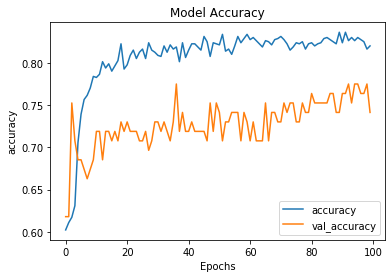

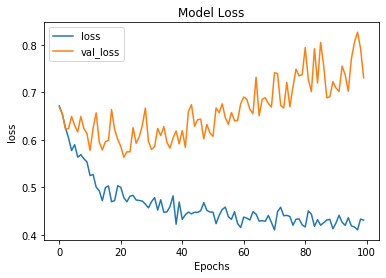

89/89 [==============================] - 0s 78us/step
[Fold 7/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6854 - accuracy: 0.5736 - val_loss: 0.6735 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 798us/step - loss: 0.6777 - accuracy: 0.5698 - val_loss: 0.6750 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 882us/step - loss: 0.6721 - accuracy: 0.5973 - val_loss: 0.6530 - val_accuracy: 0.6180
Epoch 4/100
802/802 [==============================] - 1s 895us/step - loss: 0.6491 - accuracy: 0.6097 - val_loss: 0.6341 - val_accuracy: 0.6180
Epoch 5/100
802/802 [==============================] - 1s 924us/step - loss: 0.6621 - accuracy: 0.6234 - val_loss: 0.6408 - val_accuracy: 0.6180
Epoch 6/100
802/802 [==============================] - 1s 901us/step - loss: 0.6263 - accuracy: 0.6110 - val_loss: 0.5835 - val_accuracy: 0.6180
Epoch 7/100
802/802 [

802/802 [==============================] - 1s 1ms/step - loss: 0.4620 - accuracy: 0.8117 - val_loss: 0.4505 - val_accuracy: 0.8090
Epoch 58/100
802/802 [==============================] - 1s 1ms/step - loss: 0.4424 - accuracy: 0.8279 - val_loss: 0.4576 - val_accuracy: 0.7978
Epoch 59/100
802/802 [==============================] - 1s 1ms/step - loss: 0.4651 - accuracy: 0.8192 - val_loss: 0.4396 - val_accuracy: 0.7978
Epoch 60/100
802/802 [==============================] - 1s 1ms/step - loss: 0.4676 - accuracy: 0.8092 - val_loss: 0.4390 - val_accuracy: 0.8202
Epoch 61/100
802/802 [==============================] - 1s 1ms/step - loss: 0.4469 - accuracy: 0.8254 - val_loss: 0.4523 - val_accuracy: 0.7865
Epoch 62/100
802/802 [==============================] - 1s 1ms/step - loss: 0.4697 - accuracy: 0.8105 - val_loss: 0.4421 - val_accuracy: 0.7978
Epoch 63/100
802/802 [==============================] - 1s 1ms/step - loss: 0.4561 - accuracy: 0.8117 - val_loss: 0.4504 - val_accuracy: 0.7978
Epoch

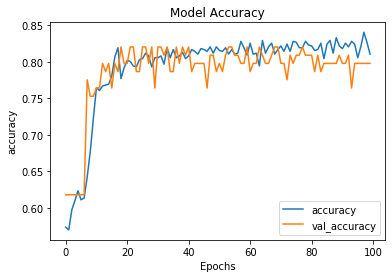

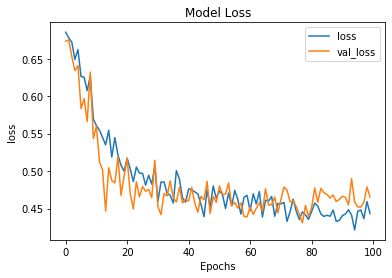

89/89 [==============================] - 0s 101us/step
[Fold 8/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6968 - accuracy: 0.5698 - val_loss: 0.6812 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 990us/step - loss: 0.6672 - accuracy: 0.5998 - val_loss: 0.6670 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6754 - accuracy: 0.5910 - val_loss: 0.6560 - val_accuracy: 0.6180
Epoch 4/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6631 - accuracy: 0.6110 - val_loss: 0.6531 - val_accuracy: 0.6180
Epoch 5/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6343 - accuracy: 0.6135 - val_loss: 0.5975 - val_accuracy: 0.6180
Epoch 6/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6392 - accuracy: 0.6185 - val_loss: 0.6238 - val_accuracy: 0.6180
Epoch 7/100
802/802 [=======

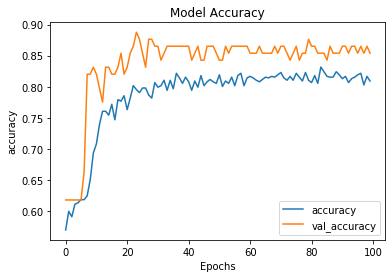

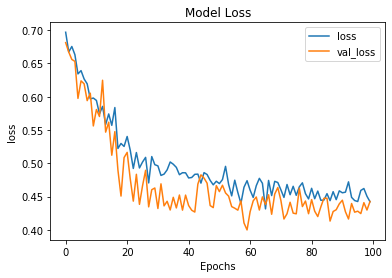

89/89 [==============================] - 0s 88us/step
[Fold 9/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6889 - accuracy: 0.5623 - val_loss: 0.6698 - val_accuracy: 0.6180
Epoch 2/100
802/802 [==============================] - 1s 962us/step - loss: 0.6848 - accuracy: 0.5898 - val_loss: 0.6543 - val_accuracy: 0.6180
Epoch 3/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6618 - accuracy: 0.6072 - val_loss: 0.6361 - val_accuracy: 0.6180
Epoch 4/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6301 - accuracy: 0.6135 - val_loss: 0.5898 - val_accuracy: 0.6180
Epoch 5/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6018 - accuracy: 0.6097 - val_loss: 0.5695 - val_accuracy: 0.6180
Epoch 6/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6042 - accuracy: 0.6297 - val_loss: 0.6149 - val_accuracy: 0.7753
Epoch 7/100
802/802 [========

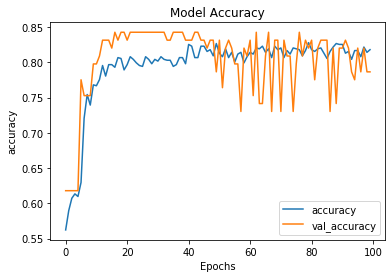

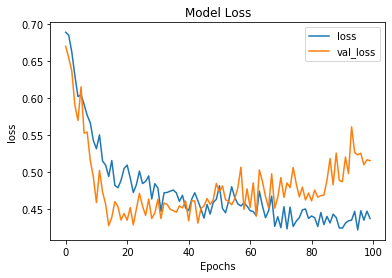

89/89 [==============================] - 0s 90us/step
[Fold 10/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 2ms/step - loss: 0.6858 - accuracy: 0.5399 - val_loss: 0.6641 - val_accuracy: 0.6067
Epoch 2/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6557 - accuracy: 0.6110 - val_loss: 0.6386 - val_accuracy: 0.6067
Epoch 3/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6458 - accuracy: 0.6185 - val_loss: 0.6226 - val_accuracy: 0.6067
Epoch 4/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6433 - accuracy: 0.5985 - val_loss: 0.6104 - val_accuracy: 0.6067
Epoch 5/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6317 - accuracy: 0.6122 - val_loss: 0.6143 - val_accuracy: 0.6067
Epoch 6/100
802/802 [==============================] - 1s 1ms/step - loss: 0.5874 - accuracy: 0.6347 - val_loss: 0.5470 - val_accuracy: 0.8427
Epoch 7/100
802/802 [=========

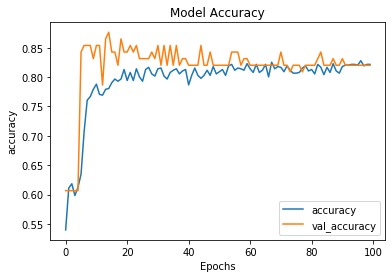

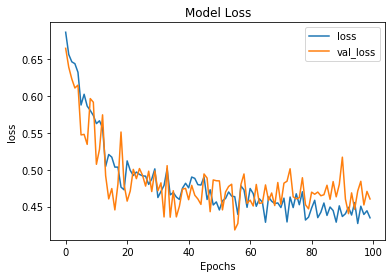

89/89 [==============================] - 0s 122us/step


In [46]:
# 10-fold Cross Validation

batch_size = 8
epochs = 100
kfold = 10

skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=111) 
skf_accuracy = []

for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index] 
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    model = model_nn()
    tf.random.set_seed(1234)

    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define callbacks list
    filepath = 'nn_crossval.hdf5'
    callbacks_list = [EarlyStopping(monitor='val_loss', verbose=1, patience=20), 
                      ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]
    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_fold, y_val_fold), verbose=1, callbacks=None)
    plot_graphs(history, 'accuracy', 'Model Accuracy')
    plot_graphs(history, 'loss', 'Model Loss')
    score = model.evaluate(X_val_fold, y_val_fold)
    val_acc = score[1]
    skf_accuracy.append(val_acc)
    

In [47]:
# Print the output
print('List of validation accuracy at each fold: {}'.format(skf_accuracy))
print('\nMaximum Validation Accuracy: {}%'.format(round(max(skf_accuracy)*100, 3)))
print('Minimum Validation Accuracy: {}%'.format(round(min(skf_accuracy)*100, 3)))
print('Overall Validation Accuracy: {}%'.format(round(mean(skf_accuracy)*100, 3)))
print('Standard Deviation is: {}'.format(round(stdev(skf_accuracy), 3)))

List of validation accuracy at each fold: [0.8333333134651184, 0.8202247023582458, 0.8089887499809265, 0.8089887499809265, 0.8202247023582458, 0.7415730357170105, 0.7977527976036072, 0.8539325594902039, 0.7865168452262878, 0.8202247023582458]

Maximum Validation Accuracy: 85.393%
Minimum Validation Accuracy: 74.157%
Overall Validation Accuracy: 80.918%
Standard Deviation is: 0.03


### 1.5.4 Convolutional Neural Network

#### 1.5.4.1 Stratified 10-Fold Cross Validation 

In [2]:
X_train = pd.read_csv("X_train_cleaned1.csv")
X_test = pd.read_csv("X_test_cleaned1.csv")
y_train = pd.read_csv("y_train_cleaned1.csv")

X_train = X_train.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)
X_test = X_test.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.values

print(type(X_train))
print(type(X_test))
print(type(y_train))
print(X_train.shape)
print(X_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(891, 15)
(418, 15)


In [3]:
# Reshape training and test dataset
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

print(X_train.shape)
print(X_test.shape)

(891, 15, 1)
(418, 15, 1)


In [4]:
# Convolutional Neural Network
def model_cnn():
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, metrics, title):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

[Fold 1/10]
Train on 801 samples, validate on 90 samples
Epoch 1/100
801/801 [==============================] - 1s 1ms/step - loss: 0.6536 - accuracy: 0.6105 - val_loss: 0.5644 - val_accuracy: 0.6556
Epoch 2/100
801/801 [==============================] - 0s 617us/step - loss: 0.5600 - accuracy: 0.7253 - val_loss: 0.4165 - val_accuracy: 0.8444
Epoch 3/100
801/801 [==============================] - 0s 619us/step - loss: 0.5111 - accuracy: 0.7815 - val_loss: 0.4108 - val_accuracy: 0.8222
Epoch 4/100
801/801 [==============================] - 1s 625us/step - loss: 0.4968 - accuracy: 0.7853 - val_loss: 0.4381 - val_accuracy: 0.8222
Epoch 5/100
801/801 [==============================] - 0s 621us/step - loss: 0.4816 - accuracy: 0.7828 - val_loss: 0.4192 - val_accuracy: 0.8222
Epoch 6/100
801/801 [==============================] - 0s 620us/step - loss: 0.4768 - accuracy: 0.8002 - val_loss: 0.4200 - val_accuracy: 0.8222
Epoch 7/100
801/801 [==============================] - 1s 627us/step - loss

Epoch 57/100
801/801 [==============================] - 0s 580us/step - loss: 0.4341 - accuracy: 0.8090 - val_loss: 0.4865 - val_accuracy: 0.8111
Epoch 58/100
801/801 [==============================] - 0s 576us/step - loss: 0.4236 - accuracy: 0.8165 - val_loss: 0.4935 - val_accuracy: 0.8111
Epoch 59/100
801/801 [==============================] - 0s 581us/step - loss: 0.4331 - accuracy: 0.8165 - val_loss: 0.4750 - val_accuracy: 0.7889
Epoch 60/100
801/801 [==============================] - 0s 579us/step - loss: 0.4180 - accuracy: 0.8152 - val_loss: 0.4903 - val_accuracy: 0.7889
Epoch 61/100
801/801 [==============================] - 0s 575us/step - loss: 0.4431 - accuracy: 0.8052 - val_loss: 0.4835 - val_accuracy: 0.8000
Epoch 62/100
801/801 [==============================] - 0s 539us/step - loss: 0.4384 - accuracy: 0.8227 - val_loss: 0.4766 - val_accuracy: 0.8000
Epoch 63/100
801/801 [==============================] - 0s 572us/step - loss: 0.4328 - accuracy: 0.8202 - val_loss: 0.4824 -

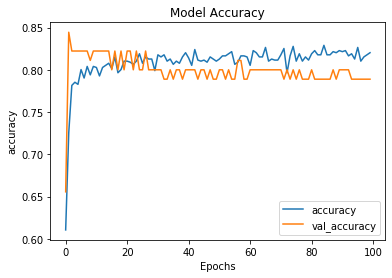

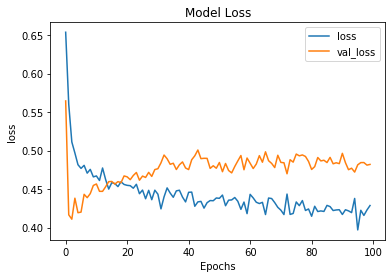

90/90 [==============================] - 0s 122us/step
[Fold 2/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6486 - accuracy: 0.6060 - val_loss: 0.5647 - val_accuracy: 0.6742
Epoch 2/100
802/802 [==============================] - 1s 653us/step - loss: 0.5559 - accuracy: 0.7494 - val_loss: 0.4832 - val_accuracy: 0.8090
Epoch 3/100
802/802 [==============================] - 0s 606us/step - loss: 0.5094 - accuracy: 0.7868 - val_loss: 0.4374 - val_accuracy: 0.8090
Epoch 4/100
802/802 [==============================] - 0s 582us/step - loss: 0.5139 - accuracy: 0.7868 - val_loss: 0.4377 - val_accuracy: 0.7978
Epoch 5/100
802/802 [==============================] - 0s 588us/step - loss: 0.4962 - accuracy: 0.7830 - val_loss: 0.4350 - val_accuracy: 0.7978
Epoch 6/100
802/802 [==============================] - 0s 587us/step - loss: 0.4730 - accuracy: 0.8005 - val_loss: 0.4272 - val_accuracy: 0.7978
Epoch 7/100
802/802 

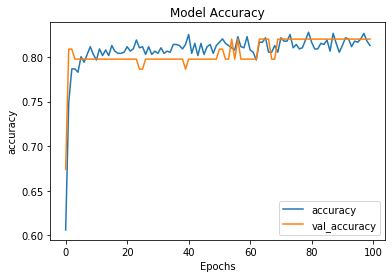

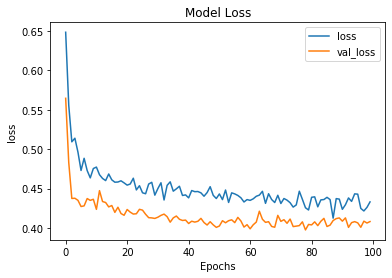

89/89 [==============================] - 0s 234us/step
[Fold 3/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6428 - accuracy: 0.6359 - val_loss: 0.5991 - val_accuracy: 0.6629
Epoch 2/100
802/802 [==============================] - 0s 615us/step - loss: 0.5639 - accuracy: 0.7481 - val_loss: 0.5508 - val_accuracy: 0.7416
Epoch 3/100
802/802 [==============================] - 0s 586us/step - loss: 0.5097 - accuracy: 0.7943 - val_loss: 0.5191 - val_accuracy: 0.7416
Epoch 4/100
802/802 [==============================] - 0s 564us/step - loss: 0.5051 - accuracy: 0.7843 - val_loss: 0.5086 - val_accuracy: 0.7416
Epoch 5/100
802/802 [==============================] - 0s 582us/step - loss: 0.4827 - accuracy: 0.7943 - val_loss: 0.4999 - val_accuracy: 0.7753
Epoch 6/100
802/802 [==============================] - 0s 595us/step - loss: 0.4891 - accuracy: 0.8005 - val_loss: 0.4944 - val_accuracy: 0.7753
Epoch 7/100
802/802 

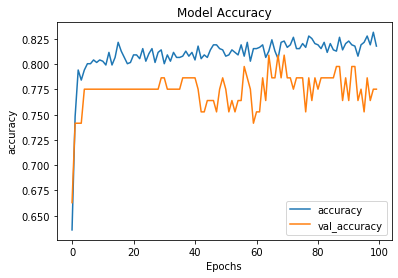

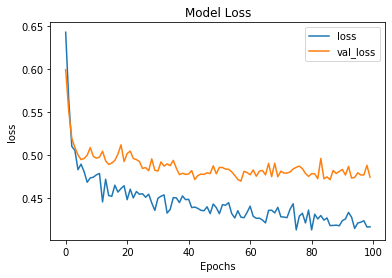

89/89 [==============================] - 0s 140us/step
[Fold 4/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6536 - accuracy: 0.6110 - val_loss: 0.5991 - val_accuracy: 0.6629
Epoch 2/100
802/802 [==============================] - 1s 664us/step - loss: 0.5357 - accuracy: 0.7382 - val_loss: 0.5456 - val_accuracy: 0.7753
Epoch 3/100
802/802 [==============================] - 1s 638us/step - loss: 0.5005 - accuracy: 0.7805 - val_loss: 0.5414 - val_accuracy: 0.7753
Epoch 4/100
802/802 [==============================] - 0s 552us/step - loss: 0.4937 - accuracy: 0.7855 - val_loss: 0.5147 - val_accuracy: 0.8202
Epoch 5/100
802/802 [==============================] - 0s 577us/step - loss: 0.4906 - accuracy: 0.7905 - val_loss: 0.5089 - val_accuracy: 0.7865
Epoch 6/100
802/802 [==============================] - 0s 614us/step - loss: 0.4661 - accuracy: 0.7843 - val_loss: 0.5010 - val_accuracy: 0.8202
Epoch 7/100
802/802 

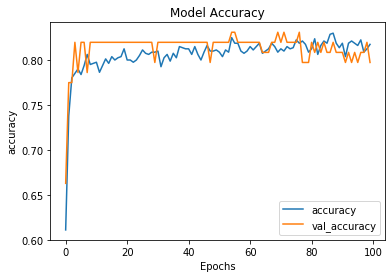

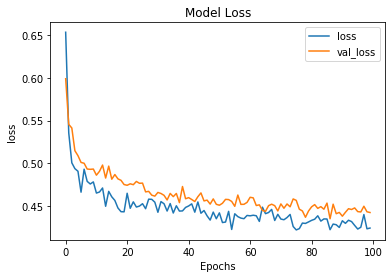

89/89 [==============================] - 0s 196us/step
[Fold 5/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6561 - accuracy: 0.6085 - val_loss: 0.6045 - val_accuracy: 0.6854
Epoch 2/100
802/802 [==============================] - 0s 609us/step - loss: 0.5424 - accuracy: 0.7519 - val_loss: 0.5333 - val_accuracy: 0.7865
Epoch 3/100
802/802 [==============================] - 0s 581us/step - loss: 0.5119 - accuracy: 0.7756 - val_loss: 0.4895 - val_accuracy: 0.7865
Epoch 4/100
802/802 [==============================] - 0s 565us/step - loss: 0.4920 - accuracy: 0.7843 - val_loss: 0.4668 - val_accuracy: 0.7865
Epoch 5/100
802/802 [==============================] - 0s 591us/step - loss: 0.4889 - accuracy: 0.7880 - val_loss: 0.4518 - val_accuracy: 0.8090
Epoch 6/100
802/802 [==============================] - 0s 556us/step - loss: 0.5000 - accuracy: 0.7830 - val_loss: 0.4584 - val_accuracy: 0.7865
Epoch 7/100
802/802 

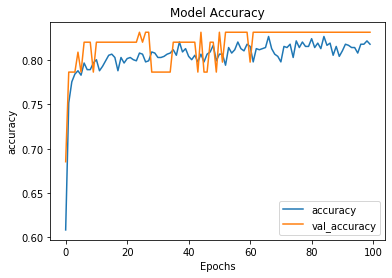

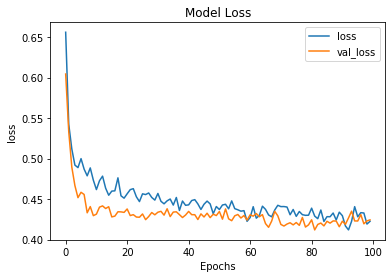

89/89 [==============================] - 0s 227us/step
[Fold 6/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6330 - accuracy: 0.6484 - val_loss: 0.6079 - val_accuracy: 0.6517
Epoch 2/100
802/802 [==============================] - 1s 683us/step - loss: 0.5205 - accuracy: 0.7731 - val_loss: 0.6445 - val_accuracy: 0.7079
Epoch 3/100
802/802 [==============================] - 0s 608us/step - loss: 0.5049 - accuracy: 0.7880 - val_loss: 0.6089 - val_accuracy: 0.7079
Epoch 4/100
802/802 [==============================] - 0s 591us/step - loss: 0.4879 - accuracy: 0.7805 - val_loss: 0.5929 - val_accuracy: 0.7528
Epoch 5/100
802/802 [==============================] - 0s 604us/step - loss: 0.4879 - accuracy: 0.7930 - val_loss: 0.5923 - val_accuracy: 0.7528
Epoch 6/100
802/802 [==============================] - 1s 626us/step - loss: 0.4630 - accuracy: 0.7980 - val_loss: 0.5781 - val_accuracy: 0.7416
Epoch 7/100
802/802 

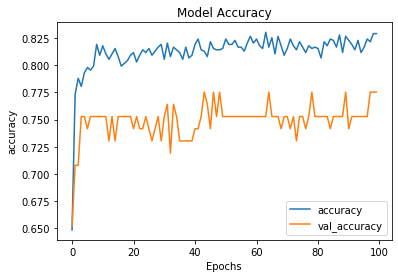

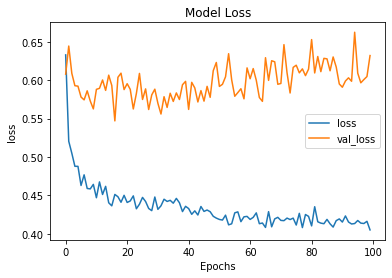

89/89 [==============================] - 0s 115us/step
[Fold 7/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6508 - accuracy: 0.6297 - val_loss: 0.5969 - val_accuracy: 0.6292
Epoch 2/100
802/802 [==============================] - 1s 645us/step - loss: 0.5506 - accuracy: 0.7431 - val_loss: 0.5068 - val_accuracy: 0.7528
Epoch 3/100
802/802 [==============================] - 1s 625us/step - loss: 0.5185 - accuracy: 0.7768 - val_loss: 0.4932 - val_accuracy: 0.7528
Epoch 4/100
802/802 [==============================] - 0s 621us/step - loss: 0.4961 - accuracy: 0.7943 - val_loss: 0.4841 - val_accuracy: 0.7528
Epoch 5/100
802/802 [==============================] - 0s 607us/step - loss: 0.4999 - accuracy: 0.7855 - val_loss: 0.4754 - val_accuracy: 0.7416
Epoch 6/100
802/802 [==============================] - 0s 579us/step - loss: 0.4813 - accuracy: 0.7943 - val_loss: 0.4706 - val_accuracy: 0.8090
Epoch 7/100
802/802 

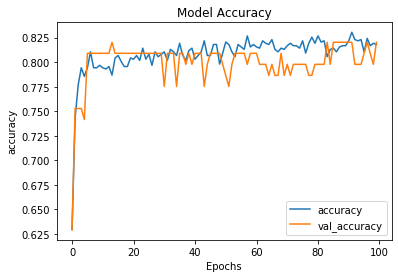

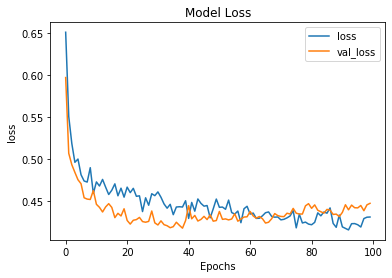

89/89 [==============================] - 0s 168us/step
[Fold 8/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6251 - accuracy: 0.6434 - val_loss: 0.4823 - val_accuracy: 0.8202
Epoch 2/100
802/802 [==============================] - 0s 609us/step - loss: 0.5261 - accuracy: 0.7631 - val_loss: 0.4152 - val_accuracy: 0.8315
Epoch 3/100
802/802 [==============================] - 0s 581us/step - loss: 0.5015 - accuracy: 0.7868 - val_loss: 0.4275 - val_accuracy: 0.8315
Epoch 4/100
802/802 [==============================] - 0s 575us/step - loss: 0.4967 - accuracy: 0.7818 - val_loss: 0.4061 - val_accuracy: 0.8315
Epoch 5/100
802/802 [==============================] - 0s 605us/step - loss: 0.4925 - accuracy: 0.7818 - val_loss: 0.4092 - val_accuracy: 0.8427
Epoch 6/100
802/802 [==============================] - 0s 575us/step - loss: 0.4898 - accuracy: 0.7918 - val_loss: 0.4212 - val_accuracy: 0.8427
Epoch 7/100
802/802 

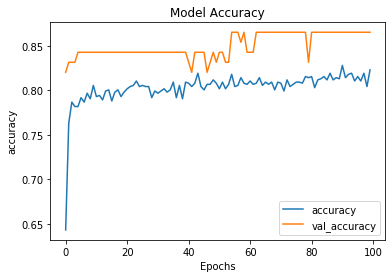

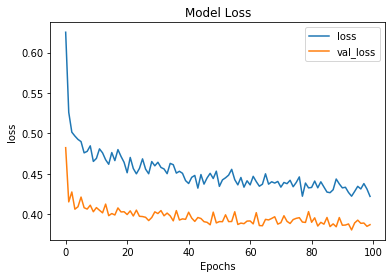

89/89 [==============================] - 0s 209us/step
[Fold 9/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6441 - accuracy: 0.6110 - val_loss: 0.5758 - val_accuracy: 0.6629
Epoch 2/100
802/802 [==============================] - 1s 649us/step - loss: 0.5580 - accuracy: 0.7456 - val_loss: 0.4899 - val_accuracy: 0.7865
Epoch 3/100
802/802 [==============================] - 0s 579us/step - loss: 0.5076 - accuracy: 0.7855 - val_loss: 0.4606 - val_accuracy: 0.7753
Epoch 4/100
802/802 [==============================] - 0s 581us/step - loss: 0.4977 - accuracy: 0.7843 - val_loss: 0.4499 - val_accuracy: 0.7753
Epoch 5/100
802/802 [==============================] - 0s 588us/step - loss: 0.4909 - accuracy: 0.7843 - val_loss: 0.4405 - val_accuracy: 0.8315
Epoch 6/100
802/802 [==============================] - 0s 592us/step - loss: 0.5005 - accuracy: 0.7793 - val_loss: 0.4277 - val_accuracy: 0.8315
Epoch 7/100
802/802 

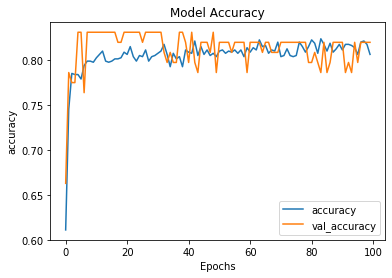

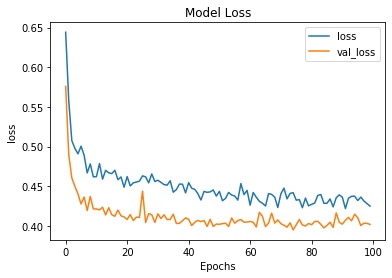

89/89 [==============================] - 0s 125us/step
[Fold 10/10]
Train on 802 samples, validate on 89 samples
Epoch 1/100
802/802 [==============================] - 1s 1ms/step - loss: 0.6410 - accuracy: 0.6359 - val_loss: 0.5161 - val_accuracy: 0.7640
Epoch 2/100
802/802 [==============================] - 0s 600us/step - loss: 0.5390 - accuracy: 0.7519 - val_loss: 0.4269 - val_accuracy: 0.8315
Epoch 3/100
802/802 [==============================] - 1s 649us/step - loss: 0.5230 - accuracy: 0.7781 - val_loss: 0.4360 - val_accuracy: 0.8315
Epoch 4/100
802/802 [==============================] - 1s 743us/step - loss: 0.5053 - accuracy: 0.7731 - val_loss: 0.4380 - val_accuracy: 0.7865
Epoch 5/100
802/802 [==============================] - 1s 672us/step - loss: 0.4924 - accuracy: 0.7968 - val_loss: 0.4253 - val_accuracy: 0.7865
Epoch 6/100
802/802 [==============================] - 1s 726us/step - loss: 0.4849 - accuracy: 0.7905 - val_loss: 0.4331 - val_accuracy: 0.8427
Epoch 7/100
802/802

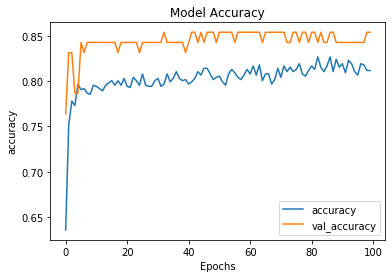

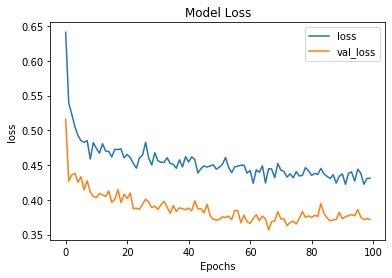

89/89 [==============================] - 0s 156us/step


In [6]:
# 10-fold Cross Validation

batch_size = 8
epochs = 100
kfold = 10

skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=111) 
skf_accuracy = []

for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index] 
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    model = model_cnn()
    tf.random.set_seed(4321)

    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define callbacks list
    filepath = 'cnn_crossval.hdf5'
    callbacks_list = [EarlyStopping(monitor='val_loss', verbose=1, patience=20), 
                      ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]
    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_fold, y_val_fold), verbose=1, callbacks=None)
    plot_graphs(history, 'accuracy', 'Model Accuracy')
    plot_graphs(history, 'loss', 'Model Loss')
    score = model.evaluate(X_val_fold, y_val_fold)
    val_acc = score[1]
    skf_accuracy.append(val_acc)

In [7]:
# Print the output
print('List of validation accuracy at each fold: {}'.format(skf_accuracy))
print('\nMaximum Validation Accuracy: {}%'.format(round(max(skf_accuracy)*100, 3)))
print('Minimum Validation Accuracy: {}%'.format(round(min(skf_accuracy)*100, 3)))
print('Overall Validation Accuracy: {}%'.format(round(mean(skf_accuracy)*100, 3)))
print('Standard Deviation is: {}'.format(round(stdev(skf_accuracy), 3)))

List of validation accuracy at each fold: [0.7888888716697693, 0.8202247023582458, 0.7752808928489685, 0.7977527976036072, 0.8314606547355652, 0.7752808928489685, 0.8202247023582458, 0.8651685118675232, 0.8202247023582458, 0.8539325594902039]

Maximum Validation Accuracy: 86.517%
Minimum Validation Accuracy: 77.528%
Overall Validation Accuracy: 81.484%
Standard Deviation is: 0.031


## 1.6 Prediction on Test Dataset using NN

In [16]:
model = model_nn()
model.summary()

# Compile the model
tf.random.set_seed(1234)
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [17]:
batch_size = 8
epochs = 100

# Early Stopping and Save Best NN model for prediction
filepath = 'nn_crossval.hdf5'
callbacks_list = [EarlyStopping(monitor='val_loss', verbose=1, patience=20), 
                  ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_val, y_val), verbose=1, callbacks=callbacks_list)

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 3s 4ms/step - loss: 0.6802 - accuracy: 0.5927 - val_loss: 0.6574 - val_accuracy: 0.6145

Epoch 00001: val_loss improved from inf to 0.65743, saving model to nn_crossval.hdf5
Epoch 2/100
712/712 [==============================] - 1s 1ms/step - loss: 0.6627 - accuracy: 0.6067 - val_loss: 0.6297 - val_accuracy: 0.6145

Epoch 00002: val_loss improved from 0.65743 to 0.62974, saving model to nn_crossval.hdf5
Epoch 3/100
712/712 [==============================] - 1s 1ms/step - loss: 0.6455 - accuracy: 0.6039 - val_loss: 0.6274 - val_accuracy: 0.6145

Epoch 00003: val_loss improved from 0.62974 to 0.62737, saving model to nn_crossval.hdf5
Epoch 4/100
712/712 [==============================] - 1s 1ms/step - loss: 0.6377 - accuracy: 0.6278 - val_loss: 0.5758 - val_accuracy: 0.7374oss: 0.6349 - ac

Epoch 00004: val_loss improved from 0.62737 to 0.57580, saving model to nn_crossval.hdf5
Epoch 5/10


Epoch 00039: val_loss did not improve from 0.44481
Epoch 40/100
712/712 [==============================] - 1s 1ms/step - loss: 0.4835 - accuracy: 0.8174 - val_loss: 0.4674 - val_accuracy: 0.8045

Epoch 00040: val_loss did not improve from 0.44481
Epoch 41/100
712/712 [==============================] - 1s 995us/step - loss: 0.4816 - accuracy: 0.8118 - val_loss: 0.4650 - val_accuracy: 0.7933

Epoch 00041: val_loss did not improve from 0.44481
Epoch 42/100
712/712 [==============================] - 1s 1ms/step - loss: 0.4504 - accuracy: 0.8301 - val_loss: 0.4609 - val_accuracy: 0.8045

Epoch 00042: val_loss did not improve from 0.44481
Epoch 43/100
712/712 [==============================] - 2s 2ms/step - loss: 0.4783 - accuracy: 0.8160 - val_loss: 0.4624 - val_accuracy: 0.8268

Epoch 00043: val_loss did not improve from 0.44481
Epoch 44/100
712/712 [==============================] - 2s 2ms/step - loss: 0.4609 - accuracy: 0.8188 - val_loss: 0.4828 - val_accuracy: 0.8045

Epoch 00044: val_

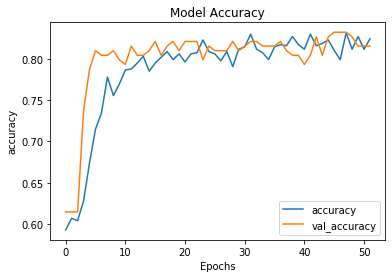

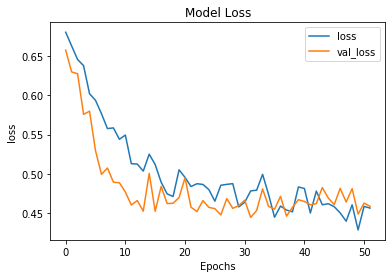

In [18]:
plot_graphs(history, 'accuracy', 'Model Accuracy')
plot_graphs(history, 'loss', 'Model Loss')

In [31]:
# Load saved NN model. Comment out the below code to load saved model.
#model = load_model('nn_crossval.hdf5')
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

179/179 [==============================] - 0s 73us/step
Validation Accuracy: 0.816
Validation Loss: 0.459


In [21]:
submission = pd.read_csv('submission.csv', index_col='PassengerId')
submission.head()

,Survived
PassengerId,
892,NaN
893,NaN
894,NaN
895,NaN
896,NaN


In [22]:
y_pred = model.predict_classes(X_test)
print(y_pred.shape)
submission['Survived'] = y_pred
submission.to_csv('submission_nn.csv')

(418, 1)


In [23]:
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [2]:
# Join predicted labels to test dataset
submission = pd.read_csv('submission_nn.csv')
X_test = pd.read_csv('X_test_cleaned1.csv')
X_test = X_test.drop(['FareGroup_0', 'FareGroup_1', 'FareGroup_2', 'FareGroup_3', 'FareGroup_4'], axis=1)
X_test['Survived_Pred'] = submission['Survived']
X_test.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_no,Family_yes,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,Survived_Pred
0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0
1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0
4,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1


In [3]:
# How many passengers survived?
# 0 = Did not survive
# 1 = Survived
X_test['Survived_Pred'].value_counts()

0    279
1    139
Name: Survived_Pred, dtype: int64

In [4]:
# How many female survivors?
female_survivor = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Sex_female']==1)]
print("Number of female survivors: {}".format(female_survivor.shape[0]))

Number of female survivors: 132


In [5]:
# How many survivors are aged 18 and below
below_18 = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['AgeGroup_0']==1)]
print("Number of survivors below 18 years old: {}".format(below_18.shape[0]))

Number of survivors below 18 years old: 16


In [6]:
# How many survivors are without family members onboard?
no_family = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Family_no']==1)]
print("Number of survivors that have no family members onboard: {}".format(no_family.shape[0]))

Number of survivors that have no family members onboard: 63


In [8]:
# Number of passengers in each ticket class
class1 = X_test.loc[(X_test['Pclass_1']==1)]
class2 = X_test.loc[(X_test['Pclass_2']==1)]
class3 = X_test.loc[(X_test['Pclass_3']==1)]
print("Number of passengers in Class 1: {}".format(class1.shape[0]))
print("Number of passengers in Class 2: {}".format(class2.shape[0]))
print("Number of passengers in Class 3: {}".format(class3.shape[0]))

Number of passengers in Class 1: 107
Number of passengers in Class 2: 93
Number of passengers in Class 3: 218


In [12]:
# Passengers from which ticket class have the least chance to survive?
bad_class1 = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Pclass_1']==1)]
bad_class2 = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Pclass_2']==1)]
bad_class3 = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Pclass_3']==1)]
print("Percentage of survivors in Class 1: {}%".format(round((bad_class1.shape[0]/class1.shape[0])*100,2)))
print("Percentage of survivors in Class 2: {}%".format(round((bad_class2.shape[0]/class2.shape[0])*100,2)))
print("Percentage of survivors in Class 3: {}%".format(round((bad_class3.shape[0]/class3.shape[0])*100,2)))

Percentage of survivors in Class 1: 49.53%
Percentage of survivors in Class 2: 34.41%
Percentage of survivors in Class 3: 24.77%


In [13]:
# Number of passengers embarked at each port
emC = X_test.loc[(X_test['Embarked_C']==1)]
emQ = X_test.loc[(X_test['Embarked_Q']==1)]
emS = X_test.loc[(X_test['Embarked_S']==1)]
print("Number of passengers embarked at Cherbourg: {}".format(emC.shape[0]))
print("Number of passengers embarked at Queenstown: {}".format(emQ.shape[0]))
print("Number of passengers embarked at Southampton: {}".format(emS.shape[0]))

Number of passengers embarked at Cherbourg: 102
Number of passengers embarked at Queenstown: 46
Number of passengers embarked at Southampton: 270


In [14]:
# Passengers from which port of embarkation have the least chance to survive?
bad_portc = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Embarked_C']==1)]
bad_portq = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Embarked_Q']==1)]
bad_ports = X_test.loc[(X_test['Survived_Pred']==1) & (X_test['Embarked_S']==1)]
print("Percentage of survivors embarked at Cherbourg: {}%".format(round((bad_portc.shape[0]/emC.shape[0])*100,2)))
print("Percentage of survivors embarked at Queenstown: {}%".format(round((bad_portq.shape[0]/emQ.shape[0])*100,2)))
print("Percentage of survivors embarked at Southampton: {}%".format(round((bad_ports.shape[0]/emS.shape[0])*100,2)))

Percentage of survivors embarked at Cherbourg: 41.18%
Percentage of survivors embarked at Queenstown: 50.0%
Percentage of survivors embarked at Southampton: 27.41%


# 2. Cifar-10 Image Classification

In [88]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from statistics import mean, stdev
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load Cifar-10 Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

170500096/170498071 [==============================] - 40s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [3]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
trainLabel, train_count = np.unique(y_train, return_counts=True)
testLabel, test_count = np.unique(y_test, return_counts=True)
print("Training Labels: {}".format(trainLabel))
print("Counts of each training class: {}".format(train_count))
print("\n")
print("Test Labels: {}".format(testLabel))
print("Counts of each test class: {}".format(test_count))

Training Labels: [0 1 2 3 4 5 6 7 8 9]
Counts of each training class: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


Test Labels: [0 1 2 3 4 5 6 7 8 9]
Counts of each test class: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [5]:
# Print a sample of training image
print(X_train[0].shape)
print(X_train[0])

(32, 32, 3)
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In [6]:
# Normalize the pixel values to values between 0 and 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255
X_test = X_test/255

print(X_train[0].shape)
print(X_train[0])

(32, 32, 3)
[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 

In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [8]:
# Convert array of integers into array of binary values. Number of columns = Number of class.
num_class = 10
y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

In [9]:
print(y_train.shape)
print(y_train[0])

(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [10]:
# Further split training data into training data and validation data.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=333)

In [43]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)
(10000, 10)


In [109]:
# Convolutional Neural Network
def model_cnn():
    model = Sequential()
    model.add(InputLayer(input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    return model

In [17]:
def plot_graphs(history, metrics, title):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

In [110]:
model = model_cnn()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 8, 8, 64)        

In [111]:
# Compile the model
tf.random.set_seed(2468)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
batch_size = 128
epochs = 50

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
313/313 [==============================] - 40s 129ms/step - loss: 1.7976 - accuracy: 0.3345 - val_loss: 1.4607 - val_accuracy: 0.4694
Epoch 2/50
313/313 [==============================] - 40s 129ms/step - loss: 1.3815 - accuracy: 0.4982 - val_loss: 1.1917 - val_accuracy: 0.5710
Epoch 3/50
313/313 [==============================] - 41s 130ms/step - loss: 1.1991 - accuracy: 0.5720 - val_loss: 1.0960 - val_accuracy: 0.6073
Epoch 4/50
313/313 [==============================] - 41s 129ms/step - loss: 1.0919 - accuracy: 0.6110 - val_loss: 1.0102 - val_accuracy: 0.6413
Epoch 5/50
313/313 [==============================] - 40s 129ms/step - loss: 1.0218 - accuracy: 0.6406 - val_loss: 0.9245 - val_accuracy: 0.6748
Epoch 6/50
313/313 [==============================] - 40s 127ms/step - loss: 0.9707 - accuracy: 0.6535 - val_loss: 0.8894 - val_accuracy: 0.6858
Epoch 7/50
313/313 [==============================] - 40s 128ms/step - loss: 0.9254 - accuracy: 0.6732 - val_loss: 0.8780 - val_ac

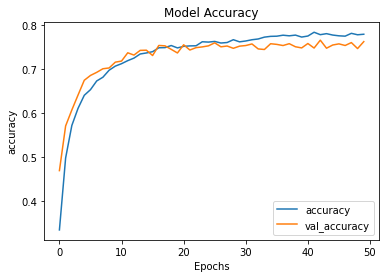

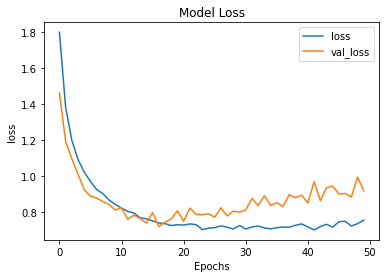

In [113]:
plot_graphs(history, 'accuracy', 'Model Accuracy')
plot_graphs(history, 'loss', 'Model Loss')

In [114]:
# Prediction on test dataset
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print("Test Accuracy: {}%".format(round((test_acc*100),3)))
print("Test Loss: {}".format(round(test_loss,3)))

313/313 [==============================] - 3s 9ms/step - loss: 0.9316 - accuracy: 0.7613
Test Accuracy: 76.13%
Test Loss: 0.932
